In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from collections import defaultdict

from tsai.basics import *

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [2]:
print(torch.cuda.is_available())

True


# Global Variables

In [3]:
batch_size = 16
fcst_history = 180
tickers= ["BP","CMCSA","CSCO","HSY","IBM","INTC","MAA","ORCL","PG","QCOM","STZ","UL","VZ","XOM"]

# Loading Train / Validation

In [4]:
train_df_scaled = pd.read_csv("data/for_model/train_default_scaled.csv")
train_df_scaled.drop(columns=["Timestamp"], inplace=True)
train_df_scaled

,BP_RSI,BP_intangibleAssets,BP_inventory,BP_Volume,BP_commonStockSharesOutstanding,BP_propertyPlantEquipment,BP_currentNetReceivables,BP_totalNonCurrentAssets,BP_goodwill,BP_Real Upper Band,...,IBM_High,INTC_High,MAA_High,ORCL_High,PG_High,QCOM_High,STZ_High,UL_High,VZ_High,XOM_High
0,0.8459,-4.340823,1.413747,0.040315,-0.547776,-3.340477,0.0,-2.917301,-1.082883,0.1361,...,-0.2300,0.32,-2.075,-1.200,-1.0995,-0.350,-4.600,-0.3700,-0.19,-0.35
1,-1.5983,-4.340823,1.413747,0.144904,-0.547776,-3.340477,0.0,-2.917301,-1.082883,0.1598,...,-0.8500,-1.05,-2.390,-0.910,0.4100,-2.380,2.195,0.2542,-0.93,-0.36
2,-0.0259,-4.340823,1.413747,0.012624,-0.547776,-3.340477,0.0,-2.917301,-1.082883,0.2195,...,0.3700,0.40,2.420,1.355,1.2000,1.600,1.775,0.8008,0.09,0.17
3,0.6661,-4.340823,1.413747,1.523358,-0.547776,-3.340477,0.0,-2.917301,-1.082883,0.2336,...,2.4732,0.90,2.660,1.675,3.1000,5.230,0.600,0.7150,0.77,0.10
4,1.1328,-4.340823,1.413747,0.293021,-0.547776,-3.340477,0.0,-2.917301,-1.082883,0.2122,...,-1.0732,-0.01,0.670,-0.640,-1.2800,-2.080,-2.045,-0.3400,-0.72,0.34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3082,1.1028,-1.751954,0.030965,1.536390,-0.337193,-3.134445,0.0,-3.336744,-6.775377,-0.1246,...,-0.8401,-0.36,-0.230,-0.460,0.0500,0.320,-0.100,0.3700,0.04,0.19
3083,0.4289,-1.751954,0.030965,0.160297,-0.337193,-3.134445,0.0,-3.336744,-6.775377,-0.1108,...,-0.2400,-0.18,-1.010,1.750,-0.0500,0.345,-0.160,-0.3300,0.12,-0.53
3084,1.1630,-1.751954,0.030965,0.625312,-0.337193,-3.134445,0.0,-3.336744,-6.775377,-0.0381,...,1.3700,0.26,0.400,0.220,0.2000,0.445,0.240,0.1900,0.07,0.54
3085,0.3817,-1.751954,0.030965,0.243472,-0.337193,-3.134445,0.0,-3.336744,-6.775377,-0.0344,...,-0.0800,0.06,0.090,0.075,0.2500,-0.120,0.170,-0.1700,-0.01,0.10


# Split

In [5]:
train_idxs_len = int(len(train_df_scaled) * 0.71)
train_idxs = np.arange(0, train_idxs_len + 1)
print(train_idxs[0], train_idxs[-1])

0 2191


In [6]:
val_idxs = np.arange(train_idxs_len + 181, len(train_df_scaled) - 180)
print(val_idxs[0], val_idxs[-1])

2372 2906


In [7]:
print(f"train: {len(train_idxs)/(len(train_idxs)+len(val_idxs))}, val: {len(val_idxs)/(len(train_idxs)+len(val_idxs))}")

train: 0.8038137147048038, val: 0.1961862852951962


In [8]:
fcst_horizon = 30
fcst_history = 180
num_y = len(tickers)
x_vars = train_df_scaled.columns

X_train = []
X_val = []

for idx in train_idxs:
    x_batch = train_df_scaled.iloc[idx:idx + fcst_history][x_vars].to_numpy().T
    X_train.append(x_batch)

for idx in val_idxs:
    x_batch = train_df_scaled.iloc[idx:idx + fcst_history][x_vars].to_numpy().T
    X_val.append(x_batch)

X_train = np.array(X_train)
X_val = np.array(X_val)
X_train.shape, X_val.shape

((2192, 266, 180), (535, 266, 180))

In [9]:
# Create datasets and dataloaders
train_dataset = TensorDataset(torch.from_numpy(X_train))
val_dataset = TensorDataset(torch.from_numpy(X_val))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [10]:
if torch.cuda.is_available():
    print("Using GPU")
    device = torch.device("cuda")  # Use GPU

Using GPU


# Encoder/Decoder

In [11]:
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1):
        super(EncoderBlock, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size, padding=padding),
            nn.BatchNorm1d(out_channels),
            nn.LeakyReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1):
        super(DecoderBlock, self).__init__()

        self.deconv = nn.Sequential(
            nn.ConvTranspose1d(in_channels, out_channels, kernel_size=kernel_size, padding=padding),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.deconv(x)
        return x
    

class FCBlock(nn.Module):
    def __init__(self, in_features, out_features, dropout_rate=0.5, reshape_output=False):
        super(FCBlock, self).__init__()
        self.reshape_output = reshape_output
        self.fc = nn.Linear(in_features, out_features)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_rate)
        
    def forward(self, x):
        batch_size = x.size(0)
        x = x.view(batch_size, -1)
        x = self.fc(x)
        x = self.relu(x)
        x = self.dropout(x)
        if self.reshape_output:
            x = x.view(batch_size, 14, X_train.shape[2])
        return x

In [12]:
class ConvSkipAutoencoder(nn.Module):
    def __init__(self, in_channels, latent_dim, dropout):
        super(ConvSkipAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.ModuleList([
            EncoderBlock(in_channels, 128, kernel_size=3, padding=1),
            EncoderBlock(128, 64, kernel_size=3, padding=1),
            EncoderBlock(64, 32, kernel_size=3, padding=1),
            EncoderBlock(32, latent_dim, kernel_size=3, padding=1),
            # Bottleneck
            # FCBlock(X_train.shape[2]*latent_dim, 1024, dropout, False),
            # FCBlock(1024, 1024, dropout, False),
            # FCBlock(1024, X_train.shape[2]*latent_dim, dropout, True)
        ])
        # Decoder
        self.decoder = nn.ModuleList([
            DecoderBlock(latent_dim, 32, kernel_size=3, padding=1),
            DecoderBlock(32, 64, kernel_size=3, padding=1),
            DecoderBlock(64+64, 128, kernel_size=3, padding=1),
            DecoderBlock(128+128, in_channels, kernel_size=3, padding=1),
        ])

    def forward(self, x):
        # Encoder
        en_outputs = []
        for encoder_layer in self.encoder:
            x = encoder_layer(x)
            en_outputs.append(x)

        # Decoder
        for i, decoder_layer in enumerate(self.decoder):
            # Skip connections
            if i == 2:
                x = torch.cat((x, en_outputs[1]), dim=1)
            if i == 3:
                x = torch.cat((x, en_outputs[0]), dim=1)
            x = decoder_layer(x)
        
        return x

In [13]:
model = ConvSkipAutoencoder(in_channels=X_train.shape[1], latent_dim=len(tickers), dropout=0.3)
model.to(device)

# Optimizer

In [16]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Loss

In [ ]:
mse_loss = nn.L1Loss()

# Callbacks

In [17]:
class LearningRateScheduler:
    def __init__(self, optimizer, decay_rate=0.1, decay_steps=10):
        self.optimizer = optimizer
        self.decay_rate = decay_rate
        self.decay_steps = decay_steps

    def __call__(self, epoch):
        if (epoch % self.decay_steps == 0) and (epoch != 0):
            print("Reducing Learning rate!")
            for param_group in self.optimizer.param_groups:
                param_group['lr'] *= self.decay_rate

class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.num_bad_epochs = 0
        self.is_better = None

    def __call__(self, val_loss):
        if self.is_better is None:
            self.is_better = lambda val_loss, best_loss: val_loss < best_loss - self.min_delta
        if self.is_better(val_loss, self.best_loss):
            self.num_bad_epochs = 0
            self.best_loss = val_loss
        else:
            self.num_bad_epochs += 1
        if self.num_bad_epochs >= self.patience:
            return True
        return False

class SaveBestModel:
    def __init__(self, model, save_path):
        self.model = model
        self.best_loss = float('inf')
        self.best_epoch = -1
        self.best_state_dict = None
        self.save_path = save_path

    def __call__(self, epoch, val_loss):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.best_epoch = epoch
            self.best_state_dict = self.model.state_dict()

            torch.save(self.best_state_dict, self.save_path)

    def restore_best_model(self):
        if self.best_state_dict is not None:
            self.model.load_state_dict(self.best_state_dict)

In [20]:
early_stopping = EarlyStopping(patience=7, min_delta=0.0)
save_best_model = SaveBestModel(model, save_path="models/autoencoder.pth")
lr_scheduler = LearningRateScheduler(optimizer, decay_rate=0.5, decay_steps=4)

# Training

Epoch [1/100], Train Loss: 0.4620, Val Loss: 0.6864
Epoch [2/100], Train Loss: 0.3962, Val Loss: 0.6289
Epoch [3/100], Train Loss: 0.3692, Val Loss: 0.6919
Epoch [4/100], Train Loss: 0.3566, Val Loss: 0.7613
Epoch [5/100], Train Loss: 0.3453, Val Loss: 0.7144
Epoch [6/100], Train Loss: 0.3464, Val Loss: 0.6765
Epoch [7/100], Train Loss: 0.3437, Val Loss: 0.6984
Epoch [8/100], Train Loss: 0.3355, Val Loss: 0.6648
Epoch [9/100], Train Loss: 0.3288, Val Loss: 0.6767
Early stopping!
Epoch [10/100], Train Loss: 0.3324, Val Loss: 0.6741
Early stopping!
Epoch [11/100], Train Loss: 0.3278, Val Loss: 0.6456
Early stopping!
Epoch [12/100], Train Loss: 0.3279, Val Loss: 0.7095
Early stopping!
Epoch [13/100], Train Loss: 0.3170, Val Loss: 0.6566
Early stopping!
Epoch [14/100], Train Loss: 0.3134, Val Loss: 0.6429
Early stopping!
Epoch [15/100], Train Loss: 0.3153, Val Loss: 0.6497
Early stopping!
Epoch [16/100], Train Loss: 0.3112, Val Loss: 0.6757
Early stopping!
Epoch [17/100], Train Loss: 0.310

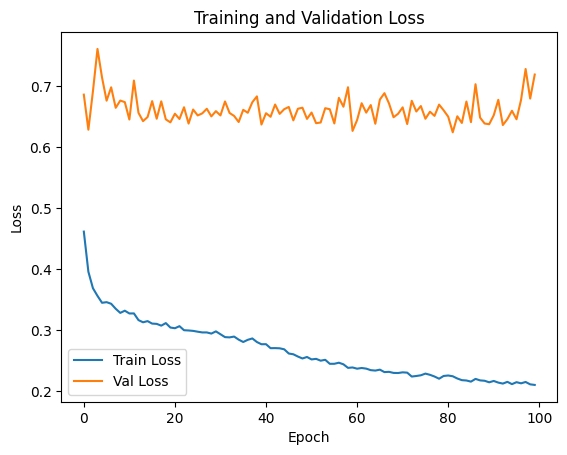

In [21]:
num_epochs = 100

history = defaultdict(list)
for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0.0
    for data in train_loader:
        inputs = data[0].float().to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = mse_loss(outputs, inputs)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    
    # Validating
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            inputs = data[0].float().to(device)
            outputs = model(inputs)
            loss = mse_loss(outputs, inputs)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    
    # Callbacks
    stop_training = early_stopping(val_loss)
    save_best_model(epoch, val_loss)
    lr_scheduler(epoch)
    
    # Save losses for plotting
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    
    if stop_training:
        print('Early stopping!')
    
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()